## Notebook to construct the resonance frequency - Sediment thickness Powerlaw Relation

#### Loads Supplementary data tables and plots the figures of the paper in below
Van Noten, K., Lecocq, T., Goffin, C., Meyvis, B., Molron, J., Debacker, T. & Devleeschouwer, X. submitted. Brussels’ bedrock paleorelief from borehole-controlled powerlaws linking polarised H/V resonance frequencies and sediment thickness. Journal of Seismology.

In [99]:
import traceback
import matplotlib
matplotlib.use("nbagg")
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import pandas as pd

from scipy.optimize import curve_fit
from matplotlib.ticker import FormatStrFormatter
from matplotlib.ticker import ScalarFormatter

## Loading the data

In [116]:
## only set borehole = 0 to create figure 6B
borehole = 1

if borehole:
    df = pd.read_csv('VanNotenetal_JOSE_S1 - Borehole HVSR analysis.csv', delimiter=',', skiprows=33, engine = 'python')
else:
    #df = pd.read_csv("HVSR Brussels survey.csv", delimiter=',', skiprows=0, engine = 'python')
    df = pd.read_csv('VanNotenetal_JOSE_S2 - Survey HVSR analysis.csv', delimiter=',', skiprows=33, engine = 'python')
    print(df)

## Define regions for which you want to compute the powerlaw relations

In [117]:
# define the groups (named R1 --> R4 in the paper)
colors = ['lightblue', 'grey', 'yellow', 'lightpink']
labels = ['R1', 'R2','R3', 'R4']

PW_sand = ['Mal', 'Ld', 'Br', 'Shh']
#PW_al_sand = ['Br_Al'] #modification 20190326: Br_AL included in the Aluvium algorithm
PW_clay = ['KoMo', 'KoSm']
PW_al_clay = ['KoMo_Al', 'KoSm_Al', 'Br_Al']
PW_pal = ['Pal_Al', 'Hn_Al']

geol_group = []
geol_color = []
error = []
for id, row in df.iterrows():
    for j, g in enumerate([PW_sand, PW_clay, PW_al_clay, PW_pal]):
        if row["Geology"] in g:
            geol_group.append(str(g))
            break
print(len(df), len(geol_group))
df["Geology"] = geol_group
print(df.head())
print(len(df))


#We deliberately delete alluvial deposits on top of Paleozoicum and Hannut out of the equation (R4)
#These alluvial deposits have completely different characteristics which cannot be linked to a general powerlaw.
PW_pal = ['Pal_Al', 'Hn_Al']
df2 = df[df["Geology"] != str(PW_pal) ] 

88 88
   Nr             Location     ID    Easting   Northing        lat       lon  \
0   1  Watermaal-Bosvoorde    C05  152808.74  166177.22  50.806039  4.408599   
1   2            Uccle ROB  Ukkel  149305.00  165170.00  50.796991  4.358893   
2   3            Uccle ROB  Ukkel  149305.00  165170.00  50.796991  4.358893   
3   4               Elsene    C08  150997.92  168012.92  50.822547  4.382914   
4   5  Sint-Stevens-Woluwe    C12  153217.39  172254.37  50.860668  4.414451   

   Z (DEM)                     Geology Region  ...          Vs  a_R1_R2_R3_R4  \
0    88.70  ['Mal', 'Ld', 'Br', 'Shh']     R3  ...  379.749884         90.422   
1   101.01  ['Mal', 'Ld', 'Br', 'Shh']     R3  ...  421.015856         90.422   
2   101.01  ['Mal', 'Ld', 'Br', 'Shh']     R3  ...  421.832749         90.422   
3    84.75  ['Mal', 'Ld', 'Br', 'Shh']     R3  ...  405.530579         90.422   
4    76.88  ['Mal', 'Ld', 'Br', 'Shh']     R3  ...  488.968204         90.422   

   b_R1_R2_R3_R4 h_Indiv  

## Fig. 5: Powerlaw regression for Brussels

<IPython.core.display.Javascript object>


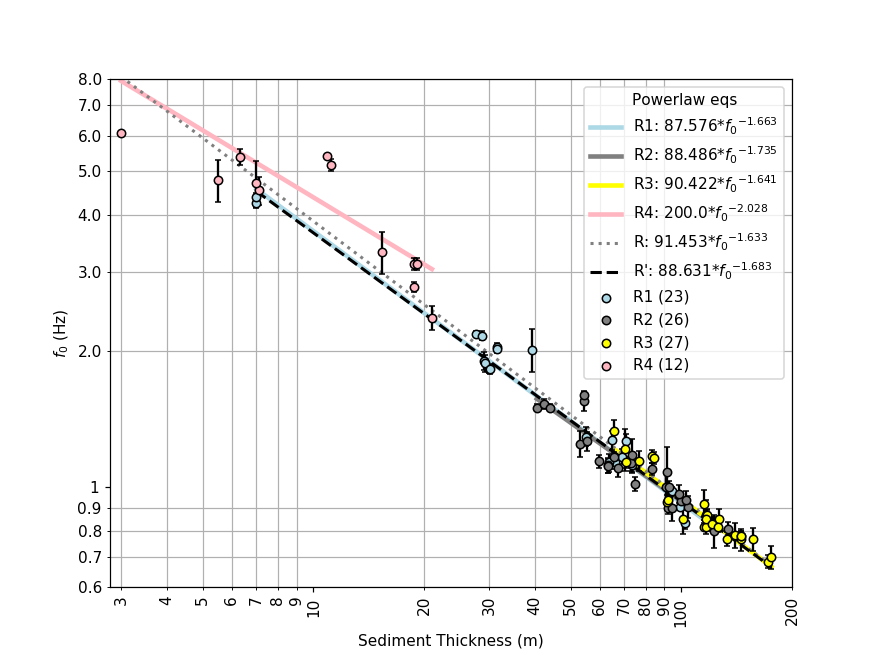

************************************************** ['KoMo', 'KoSm']
n =  23
a and b parameters= [87.57623187 -1.66259419]
R2 0.9740473045045851
************************************************** ['KoMo_Al', 'KoSm_Al', 'Br_Al']
n =  26
a and b parameters= [88.48609208 -1.73496473]
R2 0.851177619395151
************************************************** ['Mal', 'Ld', 'Br', 'Shh']
n =  27
a and b parameters= [90.42167141 -1.64075696]
R2 0.9011440611436456
************************************************** ['Pal_Al', 'Hn_Al']
n =  12
a and b parameters= [200.          -2.02784251]
R2 0.48259273283433535
************************************************** All data
n =  88
a and b parameters= [91.45262511 -1.63273091]
R2 0.9138429029548205
************************************************** All data - R4
n =  76
a and b parameters= [88.63111939 -1.68309326]
R2 0.9750791972529225


In [118]:
%matplotlib notebook

#defining the shape of the powerlaw function that needs to be fit (note: this is the inverse of the relation h = a.f0.exp(b))
def func(x, a, b):
    return (x/a)**(1.0/b)

def powerlaw(x,y,z, label_group, color, ls, linewidth):
    print("n = ", len(x))
    popt, pcov = curve_fit(func, x, y, p0=(100, -1.5),bounds=([0,-5], [200, 0.0]),
                       sigma= z, absolute_sigma=True)
    print("a and b parameters=", popt)
    a,b = popt
    xx = np.linspace(np.min(x), np.max(x), 1000)
    yy = func(xx, *popt)
    plt.plot(xx, yy, c=color, ls=ls, label='%s: %s*$f_0$$^{%s}$'%(label_group, round(popt[0],3), round(popt[1],3)), 
             linewidth = linewidth)
    yy = func(x, *popt)
    residuals = y - yy
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((y-np.mean(y))**2)
    r_squared = 1 - (ss_res / ss_tot)
    print("R2", r_squared)
    return a,b

plt.figure(figsize=(8,6))
ax = plt.subplot(111)

i = 0
#gather a and b values for later
a_values = []
b_values = []
f0_range_min = []
f0_range_max = []
groups = df.groupby("Geology")
for id, group in groups:       
    print("*"*50, id)
    Name = group["ID"]
    x = group["h"]
    y = group["f0_ip"]
    z = group["error"]
    
    # x array to interpolate values on, after curve fitting, but limited to the array data
    xx = np.linspace(np.min(x), np.max(x), 1000)

    try:
        f0_range_min.append(np.min(y))
        f0_range_max.append(np.max(y))
        
        ## perform the regression: curve fitting with scipy; bounds give you the range of the a and b values
        a,b = powerlaw(x,y,z,labels[i], colors[i], ls = '-', linewidth = 3)
        a_values.append(a)
        b_values.append(b)
    except:
        traceback.print_exc()

    plt.scatter(x, y, s=30, label = "%s (%s)"%(labels[i], len(x)), edgecolor='black', c=colors[i], zorder=4)
    #plt.scatter(x, y, s=30, edgecolor='black', label  ='', c=colors[i], zorder=4)
    
    plt.errorbar(x, y, xerr = None, yerr=z, c='black', label="", ls="none", zorder = 3, capsize=2)
        
    i+=1
    
# ************************************************** Compute powerlaw regression through all data (no group)
print("*"*50, "All data")
## for all data; check if you wanna use all data (=df) 
## or only those data without the sediments on top of the paleozoicum (other velocities) = df2
x = df["h"]
y = df["f0_ip"]
z = df["error"]
a,b = powerlaw(x,y,z,'R','grey', ls = ":", linewidth = 2)

# ************************************************** Compute powerlaw regression through all data - Region 4
print("*"*50, "All data - R4")
## for all data; check if you wanna use all data (=df) 
## or only those data without the sediments on top of the paleozoicum (other velocities) = df2
x = df2["h"]
y = df2["f0_ip"]
z = df2["error"]
a,b = powerlaw(x,y,z,"R'", 'k', ls="--", linewidth = 2)
a_values.append(a)
b_values.append(b)

##### adjust the plot and save
plt.legend(title="Powerlaw eqs", frameon=True, ncol=1)
plt.xlabel("Sediment Thickness (m)")
plt.ylabel('$f_{0}$ (Hz)')

plt.xlim(2.8,200)
plt.ylim(0.6,8)
plt.xticks(rotation='vertical')
ax.set_xscale('log')
ax.set_yscale('log')

plt.setp(ax.xaxis.get_minorticklabels(), rotation=90)
ax.xaxis.set_major_formatter(FormatStrFormatter('%.f'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.f'))
ax.xaxis.set_minor_formatter(FormatStrFormatter('%.f'))
ax.yaxis.set_minor_formatter(FormatStrFormatter('%.1f'))
plt.grid(which='minor', zorder = -3) # horizontal lines
plt.savefig("Fig. 5 - Powerlaw derivation.png", dpi=600)

plt.show()

## Figure 6: Compare amplitudes and resonance frequencies of borehole measurements and survey measurements
Make an amplitude and resonance frequency histogram of borehole measurements and survey measurements.
At the top of the notebook: Set boreholes = 1 for Fig. 6A; Set boreholes = 0 for Fig. 6B

23
26
27
12


<IPython.core.display.Javascript object>


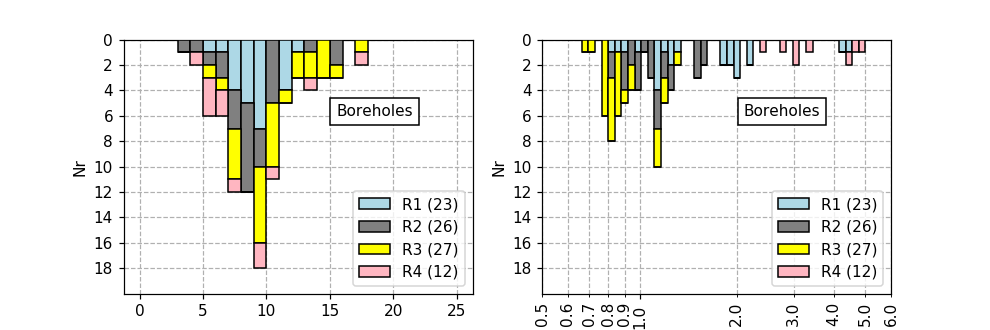

In [125]:
%matplotlib notebook

import pylab as P
import matplotlib.gridspec as gridspec
plt.close('all')

i = 0
if borehole:
    labels = ['R1 (23)', 'R2 (26)','R3 (27)', 'R4 (12)']
else:
    labels = ['R1 (32)', 'R2 (24)','R3 (343)', 'R4 (5)']
    

A0s = []
ids = []
f0s = []

for id, group in groups:
    f0 = group["f0_ip"]
    A0 = group["A0"]
    A0s.append(A0)
    ids.append(id)
    f0s.append(f0)
    print(len(group))
    
#create figure
gs = gridspec.GridSpec(1, 2, width_ratios= (1,1))
if borehole:
    plt.figure(figsize=(9, 3))
else:
    plt.figure(figsize=(9, 5))


#histogram plotter
ax0 = plt.subplot(gs[0])
bins = np.arange(0,26, 1)
n, bins, patches = P.hist(A0s, bins,orientation='vertical', color = colors, 
                          edgecolor = 'black', zorder = 5, stacked = 1, label = labels)
plt.grid(zorder = -5, ls = '--')
plt.ylabel("Nr")
if borehole:
    plt.ylim(20,0)
    plt.yticks(np.arange(0, 20, step=2))
    plt.text(15.5,6,'Boreholes', bbox=dict(facecolor='white', alpha=1))
else:
    plt.title("Amplitude")
    plt.ylim(0,70)
    plt.text(15.5,43,'Survey', bbox=dict(facecolor='white', alpha=1))
    ax0.xaxis.set_ticklabels([])
plt.legend()

ax1 = plt.subplot(gs[1])
bins=np.logspace(np.log10(0.5),np.log10(5), 50)
n, bins, patches = P.hist(f0s, bins,orientation='vertical', color = colors, edgecolor = 'black', 
                          zorder = 5, stacked = 1, label = labels)
plt.ylabel("Nr")
ax1.set_xscale("log")
plt.grid(b=True, which='major', linestyle='--')
plt.grid(b=True, which='minor', linestyle='--')


plt.setp(ax1.xaxis.get_minorticklabels(), rotation=90)
plt.xlim(0.5,6)

if borehole:
    ax1.invert_yaxis()
    plt.ylim(20,0)
    plt.yticks(np.arange(0, 20, step=2))
    plt.legend(loc=4)
    plt.xlabel("Frequency (Hz)")
    plt.xticks(rotation='vertical')
    plt.text(2.1,6,'Boreholes', bbox=dict(facecolor='white', alpha=1))
    plt.gca().xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    plt.gca().xaxis.set_minor_formatter(FormatStrFormatter('%.1f'))
    plt.savefig("Fig 6B - Amplitude - f0 histogram - boreholes.png", dpi=600) 
    
else:
    plt.title("Resonance frequency (Hz)")
    plt.ylim(0,70)
    plt.text(2.1,43,'Survey', bbox=dict(facecolor='white', alpha=1))
    ax1.xaxis.set_ticklabels([])
    plt.legend()
    plt.savefig("Fig 6A - Amplitude - f0 histogram - survey.png", dpi=600)
    
plt.show()

## Fig. 7A: Computation of residuals between predicted bedrock depth and true bedrock depth

<IPython.core.display.Javascript object>


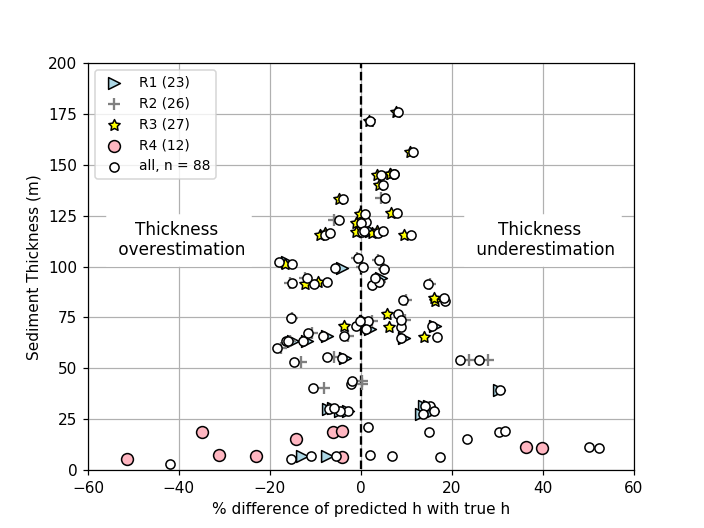

************************************************** ['KoMo', 'KoSm']
n =  23
************************************************** ['KoMo_Al', 'KoSm_Al', 'Br_Al']
n =  26
************************************************** ['Mal', 'Ld', 'Br', 'Shh']
n =  27
************************************************** ['Pal_Al', 'Hn_Al']
n =  12


In [126]:
%matplotlib notebook
# change percentage to False if you want to plot the absolute values
Percentage = True
plt.close('all')
plt.figure()
ax = plt.axes()  

groups = df.groupby("Geology")

diff_indivs = []
Th_cali_1PWs = []
diff_1PWs = []

labels = ['R1 (23)', 'R2 (26)','R3 (27)', 'R4 (12)']
markers = ['>', '+', (5,1), 'o']

## first plot the residuals of the individual groups
i = 0
for label, (id, group), marker in zip(labels, groups, markers):
    print("*"*50, id)
    print('n = ', len(group))
    x = group["h"]
    y = group["f0_ip"]
    z = group["error"]

    Th_cali_indiv = a_values[i]*np.power(y,b_values[i])
    
    #Thickness for several PW
    diff_indiv = x - Th_cali_indiv
    diff_indivs.append(diff_indiv)
    
    #Thickness for 1 PW
    diff_1PWs.append(x - (a*np.power(y,b)))
    
    #PLOT THE DIFFERENCE in %
    if Percentage:
        plt.scatter(diff_indiv/x*100,x, label=label, color = colors[i], edgecolor = 'black', zorder = 3, marker = marker, s = 60) 
    #PLOT THE ABSOLUTE DIFFERENCE
    else:
        plt.scatter(x,diff_indiv, label=label, color = colors[i],edgecolor = 'black', zorder = 3)

    i+=1

## plot residuals of the regional regression R'
a_Rprime = a_values[4]
b_Rprime = b_values[4]
Th_cali_1PW = a_Rprime*np.power(df["f0_ip"],b_Rprime)
diff_1PW = df["h"] - Th_cali_1PW

if Percentage:
    plt.scatter(diff_1PW/df["h"]*100, df["h"], c='white',edgecolor = 'black', 
                label="all, n = %s"%len(diff_1PW),zorder = 3)
    plt.xlabel('% difference of predicted h with true h') #PLOT THE DIFFERENCE in %
else:
    plt.scatter(df["h"],diff_1PW, c='red',edgecolor = 'black',label="all, n = %s"%len(diff_all), zorder = 3)
    plt.xlabel('$h_{ True}$ - $h_{ modelled}$', fontsize = 11) #PLOT THE ABSOLUTE DIFFERENCE

## adjust plot
plt.legend(loc='upper left',fontsize=9, ncol = 1)
plt.ylim(0,200)
plt.ylabel("Sediment Thickness (m)")
plt.axvline(0,500,0, ls='--', c='black')
plt.xlim(-60,60)
t = plt.text(40, 105.5, 'Thickness \n underestimation', fontsize = 11, ha = 'center')
t2 = plt.text(-40,105.5, 'Thickness \n overestimation', fontsize = 11, ha = 'center')
t.set_bbox(dict(facecolor='white', edgecolor='white'))
t2.set_bbox(dict(facecolor='white', edgecolor='white'))

plt.grid(zorder = -200)
plt.savefig("Fig. 7A - residual computation.png", dpi=300)
plt.show()

## Fig. 7B residual histogram

<IPython.core.display.Javascript object>


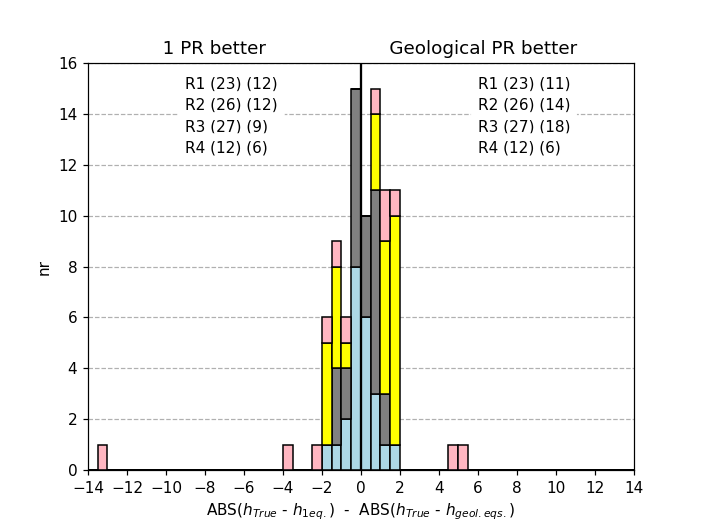

1 PR better: 39
Geological PR better: 49


C:\Program Files (x86)\Anaconda\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
C:\Program Files (x86)\Anaconda\lib\site-packages\matplotlib\figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


In [127]:
import pylab as P

plt.close('all')
## difference between 1 PW residuals or geologically-dependant residuals
all_indiv =  np.absolute(np.array(diff_1PWs)) - np.absolute(np.array(diff_indivs))
onePW = []
allPW = []
onePW_id = []
allPW_id = []

p = 0
for i,(id, group),label in zip(all_indiv, groups,labels):
    for j in i:
        if j < 0:
            onePW_id.append(j)
            onePW.append(j)
        else:
            allPW_id.append(j)
            allPW.append(j)
    ########1 PW better
    t = plt.text(-9,15-p/1.2,"%s (%s)"%(labels[p], len(onePW_id)))
    t.set_bbox(dict(facecolor='white', edgecolor='white'))
    ########Geol PW better
    t = plt.text(6,15-p/1.2,"%s (%s)"%(labels[p], len(allPW_id)))
    t.set_bbox(dict(facecolor='white', edgecolor='white'))
    onePW_id = []
    allPW_id = []

    p = p+1

print('1 PR better:', len(onePW))
print('Geological PR better:',len(allPW))
bins = np.arange(-16,16,0.5)      #define the bin width of the histogram

n, bins, patches = P.hist(all_indiv, bins, normed=0, histtype='bar', 
                          edgecolor = 'black', color = ['lightblue', 'grey', 'yellow','lightpink'], 
                          rwidth=1, orientation = 'vertical', zorder = 2, stacked=1)

plt.xlabel('ABS($h_{True}$ - $h_{1 eq.})$  -  ABS($h_{ True}$ - $h_{geol. eqs.})$')
plt.ylabel('nr')
plt.axvline(0,0,100, c='black', zorder = 2)

ax = plt.axes() 
ax.yaxis.grid(ls = '--',zorder = -3)
plt.xticks(np.arange(-14, 16, 2))
plt.ylim(0,16)
plt.xlim(-14,14)
plt.title("   1 PR better                     Geological PR better")

plt.savefig("Fig 7B - comparing residuals.png", dpi=300)

plt.show()

## Fig. 8: Velocity plot

<IPython.core.display.Javascript object>


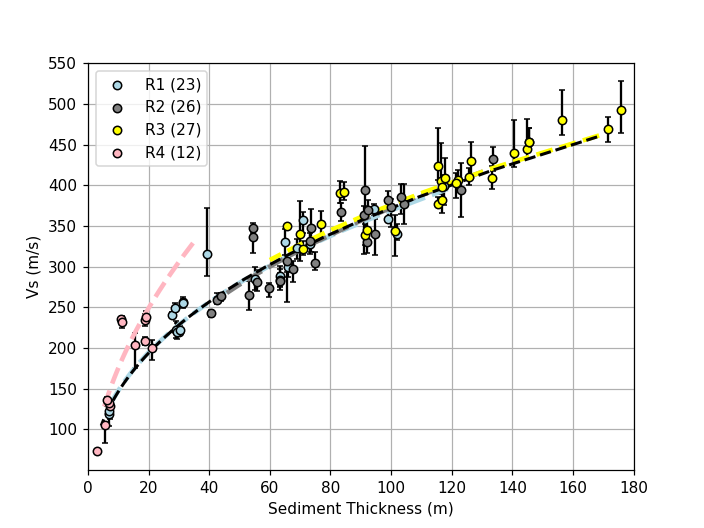

************************************************** ['KoMo', 'KoSm']
************************************************** ['KoMo_Al', 'KoSm_Al', 'Br_Al']
************************************************** ['Mal', 'Ld', 'Br', 'Shh']
************************************************** ['Pal_Al', 'Hn_Al']


In [128]:
%matplotlib notebook

i = 0
plt.figure()
plt.grid(zorder = -5)
labels = ['R1', 'R2','R3', 'R4']
for label,(id, group) in zip(labels,groups):
    print("*"*50, id)
    f0 = group["f0_ip"]
    h = group["h"]
    Vs = 4*f0*h
    plt.scatter(h,Vs, label = "%s (%s)"%(labels[i], len(h)), s=30, edgecolor = 'black', linewidth='1', c=colors[i], zorder = 3)
    y_errmax = 4*group["f0 min"]*h - Vs
    y_errmin = Vs - (4*group["f0 max"]*h)
    plt.errorbar(h,Vs,xerr=None,yerr=[y_errmin, y_errmax], ls='none', capsize=2, c = 'black',zorder = 2)
    i+=1

def PW(a,b,color, f0_range_min,f0_range_max, lw):
    f0_int = np.arange(f0_range_min,f0_range_max,0.1)  
    h_int = a*np.power(f0_int,b)
    Vs_int = h_int * f0_int * 4  
    plt.plot(h_int, Vs_int, c = color, ls='--', zorder = 2, linewidth=lw)

#For all individual regressions
for i in np.arange(0,4,1):
    PW(a_values[i],b_values[i],colors[i], f0_range_min[i],f0_range_max[i], lw = 3)

#For one regression
a_Rprime = a_values[4]
b_Rprime = b_values[4]
PW(a_Rprime,b_Rprime,'black',np.min(f0_range_min),np.max(f0_range_max), lw = 2)
    
plt.legend(frameon=True, ncol=1)
plt.annotate("n = %s"%len(df2),(1.1,5))
plt.ylabel("Vs (m/s)")
plt.xlabel("Sediment Thickness (m)")
plt.xlim(0,180)
plt.ylim(50,550)
plt.yticks(np.arange(100, 600, 50))
plt.savefig('Fig 8 - Vs versus thickness.jpg')

plt.show()